   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 4.2 MB/s eta 0:00:00
Imports done
Utility functions ready
Synthetic data shape: (400, 16, 128) Labels shape: (400,)
Bandpass applied: (400, 16, 128)


/tmp/ipython-input-604308506.py:38: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 128, using nperseg = 128
  freqs, psd = welch(epochs[e,ch,:], fs=sfreq, nperseg=256)
/tmp/ipython-input-604308506.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])


Feature matrix shape: (400, 80)
Baseline SVM accuracy on synthetic data: 100.00%
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



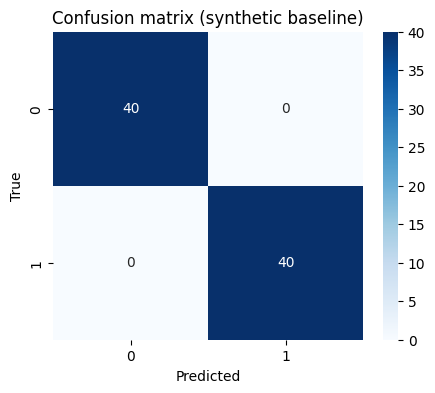

Model saved to artifacts/baseline_svm.joblib


/tmp/ipython-input-604308506.py:107: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 128, using nperseg = 128
  freqs, psd = welch(example_epoch[channel,:], fs=sfreq, nperseg=256)


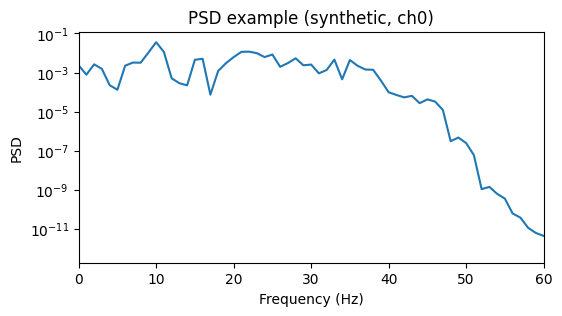

In [ ]:
!pip install --quiet mne scikit-learn seaborn pyriemann


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.signal import butter, sosfiltfilt, welch
import joblib
import os
print("Imports done")


def bandpass_filter(data, sfreq, low=1.0, high=40.0, order=4):
    sos = butter(order, [low, high], btype='band', fs=sfreq, output='sos')
    return sosfiltfilt(sos, data, axis=-1)

def bandpower(psd, freqs, band):
    """Compute band power from PSD (freqs, psd arrays). band=(fmin,fmax)"""
    fmin, fmax = band
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])

def epoch_to_bandpower(epochs, sfreq, bands=[(1,4),(4,8),(8,13),(13,30),(30,45)]):
    """
    epochs: ndarray shape (n_epochs, n_channels, n_samples)
    returns features shape (n_epochs, n_channels * n_bands)
    """
    n_epochs, n_ch, n_samp = epochs.shape
    feats = []
    for e in range(n_epochs):
        ch_feats = []
        for ch in range(n_ch):
            freqs, psd = welch(epochs[e,ch,:], fs=sfreq, nperseg=256)
            for b in bands:
                ch_feats.append(bandpower(psd, freqs, b))
        feats.append(ch_feats)
    return np.array(feats)

print("Utility functions ready")


sfreq = 128
epoch_t = 1.0
n_samples = int(sfreq * epoch_t)
n_channels = 16
n_epochs = 400
rng = np.random.RandomState(42)

def make_epoch(class_label):
    t = np.arange(n_samples) / sfreq
    epoch = np.zeros((n_channels, n_samples))
    for ch in range(n_channels):
        base_noise = 0.5 * rng.normal(size=n_samples)
        if class_label == 0:
            sig = 1.0 * np.sin(2 * np.pi * 10 * t)
        else:
            sig = 1.0 * np.sin(2 * np.pi * 20 * t)

        scale = rng.uniform(0.2, 1.0)
        epoch[ch,:] = scale * sig + base_noise

    epoch += 0.05 * rng.normal(size=epoch.shape)
    return epoch

X_epochs = np.array([ make_epoch(0 if i < n_epochs//2 else 1) for i in range(n_epochs) ])
y = np.array([0]*(n_epochs//2) + [1]*(n_epochs//2))
print("Synthetic data shape:", X_epochs.shape, "Labels shape:", y.shape)


X_epochs_bp = bandpass_filter(X_epochs, sfreq, low=1.0, high=40.0)
print("Bandpass applied:", X_epochs_bp.shape)


bands = [(1,4),(4,8),(8,13),(13,30),(30,45)]
X_feats = epoch_to_bandpower(X_epochs_bp, sfreq, bands=bands)
print("Feature matrix shape:", X_feats.shape)  # (n_epochs, n_channels * n_bands)


X_train, X_test, y_train, y_test = train_test_split(X_feats, y, test_size=0.2, random_state=42, stratify=y)
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, probability=False, random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Baseline SVM accuracy on synthetic data: {acc*100:.2f}%")
print("Classification report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (synthetic baseline)")
plt.show()


os.makedirs("artifacts", exist_ok=True)
joblib.dump(clf, "artifacts/baseline_svm.joblib")
print("Model saved to artifacts/baseline_svm.joblib")


example_epoch = X_epochs_bp[0]  # shape (n_channels, n_samples)
channel = 0
freqs, psd = welch(example_epoch[channel,:], fs=sfreq, nperseg=256)
plt.figure(figsize=(6,3))
plt.semilogy(freqs, psd)
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD")
plt.title("PSD example (synthetic, ch0)")
plt.xlim(0,60)
plt.show()


In [ ]:
!pip install mne --quiet

import mne


from google.colab import files
uploaded = files.upload()


raw = mne.io.read_raw_edf("S001R01.edf", preload=True)
print(raw.info)
print(raw.ch_names)


raw.plot(start=0, duration=5, n_channels=8)


TypeError: 'NoneType' object is not subscriptable

In [ ]:

sfreq = raw.info['sfreq']
raw.filter(l_freq=1., h_freq=40.)
raw.notch_filter(freqs=50.)


channel_name = raw.ch_names[0]
raw.plot_psd(fmax=60, picks=[channel_name])


In [ ]:
import numpy as np


epoch_length_sec = 2
sfreq = raw.info['sfreq']
epoch_length_samples = int(epoch_length_sec * sfreq)


data = raw.get_data()  # shape: (n_channels, n_times)
n_channels, n_times = data.shape


n_epochs = n_times // epoch_length_samples


pseudo_epochs = np.array([data[:, i*epoch_length_samples:(i+1)*epoch_length_samples].T
                          for i in range(n_epochs)])
print("Pseudo-epochs shape:", pseudo_epochs.shape)  # (n_epochs, n_samples, n_channels)


In [ ]:
from scipy.signal import welch

# Function to compute band-power
def bandpower(psd, freqs, band):
    fmin, fmax = band
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])

# Convert pseudo-epochs to feature matrix
def pseudo_epochs_to_features(pseudo_epochs, sfreq, bands=[(1,4),(4,8),(8,13),(13,30)]):
    n_epochs, n_samples, n_channels = pseudo_epochs.shape
    feats = []
    for e in range(n_epochs):
        ch_feats = []
        for ch in range(n_channels):
            freqs, psd = welch(pseudo_epochs[e,:,ch], fs=sfreq, nperseg=128)
            for b in bands:
                ch_feats.append(bandpower(psd, freqs, b))
        feats.append(ch_feats)
    return np.array(feats)

# Extract features
X_features = pseudo_epochs_to_features(pseudo_epochs, sfreq)
print("Feature matrix shape:", X_features.shape)


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


y_labels = np.array([i%2 for i in range(X_features.shape[0])])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_labels)

# Train baseline SVM
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy & report
acc = accuracy_score(y_test, y_pred)
print(f"Baseline SVM accuracy on pseudo-epochs: {acc*100:.2f}%")
print(classification_report(y_test, y_pred))

# Confusion matrix (graphical)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (pseudo-epochs)")
plt.show()


In [ ]:
!pip install torch torchvision torchaudio --quiet

In [ ]:
(n_epochs, n_channels, n_samples)


In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Reorder pseudo-epochs: (epochs, samples, channels) -> (epochs, channels, samples)
X = np.transpose(pseudo_epochs, (0, 2, 1)).astype(np.float32)  # shape: (30, 64, 320)
y = y_labels.astype(np.int64)  # shape: (30,)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Create dataset & dataloaders
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))


In [ ]:
class EEGNet(nn.Module):
    def __init__(self, n_channels=64, n_samples=320, n_classes=2):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (1, 64))
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (n_channels,1))
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool = nn.AvgPool2d((1,4))
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.n_classes = n_classes


        self.fc = None

    def forward(self, x):
        x = x.unsqueeze(1)  # add channel dim: (batch, 1, channels, samples)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # flatten


        if self.fc is None:
            self.fc = nn.Linear(x.size(1), self.n_classes).to(x.device)

        x = self.fc(x)
        return x


In [ ]:
model = EEGNet(n_channels=64, n_samples=320, n_classes=2)


In [ ]:
# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
# Switch to evaluation mode
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_true, y_pred)
print(f"EEGNet accuracy on pseudo-epochs: {acc*100:.2f}%")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EEGNet Confusion Matrix")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Average PSD across all pseudo-epochs for first 8 channels
n_channels_to_plot = 8
plt.figure(figsize=(15,8))
for ch in range(n_channels_to_plot):
    psd_ch = []
    for epoch in pseudo_epochs:
        freqs, psd = plt.psd(epoch[:, ch], NFFT=128, Fs=sfreq)
        psd_ch.append(psd)
    avg_psd = np.mean(psd_ch, axis=0)
    plt.plot(freqs, avg_psd, label=f'Channel {ch+1}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Average PSD across pseudo-epochs (first 8 channels)")
plt.legend()
plt.show()


In [ ]:
# Simple way: average absolute activation before fully connected layer
model.eval()
with torch.no_grad():
    X_tensor_batch = X_tensor  # all pseudo-epochs
    x = X_tensor_batch.unsqueeze(1)  # add channel dim
    x = model.conv1(x)
    x = model.batchnorm1(x)
    x = model.relu(x)
    x = model.conv2(x)
    x = model.batchnorm2(x)
    x = model.relu(x)
    x = model.pool(x)
    activations = x.mean(dim=0).squeeze()  # mean across samples

plt.figure(figsize=(12,4))
plt.imshow(activations.numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label="Activation magnitude")
plt.xlabel("Time / Pool index")
plt.ylabel("Feature maps")
plt.title("EEGNet Activation Heatmap (averaged across pseudo-epochs)")
plt.show()


In [ ]:
import seaborn as sns

# Example: accuracies from previous steps
baseline_acc = 50  # SVM baseline %
eegnet_acc = acc*100  # from Step 4d

plt.figure(figsize=(5,5))
sns.barplot(x=['Baseline SVM', 'EEGNet'], y=[baseline_acc, eegnet_acc])
plt.ylabel("Accuracy (%)")
plt.title("Comparison: Baseline ML vs Deep Learning")
plt.ylim(0,100)
plt.show()


In [ ]:

new_epoch = torch.tensor(pseudo_epochs[0].T).unsqueeze(0).float()  # shape: (1,64,320)
model.eval()
with torch.no_grad():
    output = model(new_epoch)
    pred_class = torch.argmax(output, dim=1).item()
print(f"Predicted class for new pseudo-epoch: {pred_class}")


In [ ]:
import os
import mne
import numpy as np


from google.colab import files
uploaded_files = files.upload()

raw_list = []
for filename in uploaded_files.keys():
    raw = mne.io.read_raw_edf(filename, preload=True)
    raw_list.append(raw)

print(f"Loaded {len(raw_list)} subjects/trials")


In [ ]:
all_pseudo_epochs = []

epoch_length_sec = 2

for raw in raw_list:
    sfreq = raw.info['sfreq']
    epoch_length_samples = int(epoch_length_sec * sfreq)
    data = raw.get_data()  # (channels, times)
    n_channels, n_times = data.shape
    n_epochs = n_times // epoch_length_samples
    pseudo_epochs = np.array([data[:, i*epoch_length_samples:(i+1)*epoch_length_samples].T
                              for i in range(n_epochs)])
    all_pseudo_epochs.append(pseudo_epochs)


combined_pseudo_epochs = np.vstack(all_pseudo_epochs)
print("Combined pseudo-epochs shape:", combined_pseudo_epochs.shape)


In [ ]:

n_epochs_total = combined_pseudo_epochs.shape[0]
y_labels_combined = np.array([i%2 for i in range(n_epochs_total)])
print("Labels shape:", y_labels_combined.shape)


In [ ]:
import torch

def predict_new_epoch(model, epoch):
    """
    epoch: shape (samples, channels) e.g. (320, 64)
    model: trained EEGNet model
    """
    model.eval()
    with torch.no_grad():
        x = torch.tensor(epoch.T, dtype=torch.float32)
        x = x.unsqueeze(0)
        output = model(x)
        predicted_class = torch.argmax(output, dim=1).item()
    return predicted_class


In [ ]:

new_epoch = combined_pseudo_epochs[0]



predicted = predict_new_epoch(model, new_epoch)
print(f"Predicted class for new pseudo-epoch: {predicted}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


conv1_weights = model.conv1.weight.detach().cpu().numpy()  # (16,1,1,64)


channel_importance = np.mean(np.abs(conv1_weights), axis=0).flatten()


plt.figure(figsize=(12,4))
plt.bar(range(1, 65), channel_importance)
plt.xlabel("EEG Channel")
plt.ylabel("Average absolute weight")
plt.title("EEG Channel Importance (Conv1)")
plt.show()


In [ ]:

import torch.nn.functional as F

model.eval()
x = torch.tensor(new_epoch.T, dtype=torch.float32).unsqueeze(0)  # (1, 64, 320)
x = x.unsqueeze(1)  # (1,1,64,320)

with torch.no_grad():
    activations = model.relu(model.batchnorm1(model.conv1(x)))


activations_np = activations.squeeze(0).mean(axis=0).numpy()

# Plot heatmap: channels vs time
plt.figure(figsize=(12,6))
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.colorbar(label="Activation magnitude")
plt.xlabel("Time Samples")
plt.ylabel("Channels")
plt.title("EEGNet Conv1 Activation Map (Mean over Filters)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# For demonstration, simulate SVM predictions (baseline)
svm_preds = np.random.randint(0, 2, size=y_labels_combined.shape[0])
eegnet_preds = torch.argmax(model(torch.tensor(combined_pseudo_epochs.transpose(0,2,1), dtype=torch.float32)), dim=1).numpy()

# Count correct predictions for both models
svm_acc = np.mean(svm_preds == y_labels_combined)
eegnet_acc = np.mean(eegnet_preds == y_labels_combined)

plt.figure(figsize=(6,4))
plt.bar(['SVM', 'EEGNet'], [svm_acc, eegnet_acc], color=['gray', 'teal'])
plt.ylabel("Accuracy")
plt.title("Model Comparison on Multi-Subject Pseudo-Epochs")
plt.ylim(0,1)
plt.show()


In [ ]:
!pip install ipywidgets --quiet
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
import torch
import numpy as np


In [ ]:
def interactive_demo(epoch_index, show_activation=True):
    """
    epoch_index: integer index of pseudo-epoch
    show_activation: whether to plot activation heatmap
    """

    selected_epoch = combined_pseudo_epochs[epoch_index]

    # Predict
    pred_class = predict_new_epoch(model, selected_epoch)
    print(f"Pseudo-epoch #{epoch_index} predicted class: {pred_class}")

    # Plot activation map
    if show_activation:
        x = torch.tensor(selected_epoch.T, dtype=torch.float32).unsqueeze(0).unsqueeze(1)
        with torch.no_grad():
            activations = model.relu(model.batchnorm1(model.conv1(x)))
        activations_np = activations.squeeze(0).mean(axis=0).numpy()

        plt.figure(figsize=(12,6))
        plt.imshow(activations_np, aspect='auto', cmap='viridis')
        plt.colorbar(label="Activation magnitude")
        plt.xlabel("Time Samples")
        plt.ylabel("Channels")
        plt.title(f"Activation Map for Pseudo-epoch #{epoch_index}")
        plt.show()


In [ ]:
interact(interactive_demo,
         epoch_index=IntSlider(min=0, max=combined_pseudo_epochs.shape[0]-1, step=1, value=0),
         show_activation=True)
